<a href="https://colab.research.google.com/github/mralamdari/Computer-Vision-Projects/blob/main/Parking_spot_detection_Complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import os
import cv2
import pickle
import shutil
import sklearn
import skimage
import zipfile
import IPython
import scipy.io
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from sklearn import svm
import tensorflow_datasets
from sklearn import metrics
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from sklearn import model_selection

In [28]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive'
!kaggle datasets download -d blanderbuss/parking-lot-dataset
!unzip \*.zip && rm *.zip
IPython.display.clear_output()

#Image Classifier
At first we need to create a model to predict if a spot shown in the image is Empty or Occupied.

We use the [**parking lot dataset**](https://www.kaggle.com/datasets/blanderbuss/parking-lot-dataset) from kaggle for both classification and detection tasks.

###Data

In [ ]:
cls_data = './PKLot/PKLotSegmented'
train_path = './data/train'
val_path   = './data/validation'
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

VAL_THRESHOLD = 0.2

In [ ]:
#since the models are big so we need to select only a portion of the data so the ram won't get fulled
limit = 80
data_arr = []

for cat in os.listdir(cls_data):
  for crs in os.listdir(cls_data+'/'+cat):
    for day in os.listdir(cls_data+'/'+cat+'/'+crs):
      for E_O in os.listdir(cls_data+'/'+cat+'/'+crs+'/'+day):
        for img in os.listdir(cls_data+'/'+cat+'/'+crs+'/'+day+'/'+E_O)[:limit]:
          path = os.path.join(cls_data, cat, crs, day, E_O, img)
          folder_name = train_path if np.random.randn()<VAL_THRESHOLD else val_path
          target = os.path.join(folder_name, img)
          label = 0 if E_O == 'Empty' else 1
          data_arr.append([target, label])
          os.replace(path, target)


data = pd.DataFrame(data_arr, columns=['path', 'label'])
data

,path,label
0,./data/validation/2013-03-14_06_55_01#024.jpg,0
1,./data/train/2013-03-14_06_50_01#012.jpg,0
2,./data/train/2013-03-14_18_31_06#028.jpg,0
3,./data/validation/2013-03-14_06_40_00#033.jpg,0
4,./data/validation/2013-03-14_18_11_06#002.jpg,0
...,...,...
19981,./data/train/2012-12-15_17_10_14#002.jpg,0
19982,./data/train/2012-12-15_16_55_14#011.jpg,0
19983,./data/train/2012-12-15_17_05_14#003.jpg,0
19984,./data/validation/2012-12-15_17_20_14#015.jpg,0


In [ ]:
data.groupby(['label']).count()

,path
label,
0,10280
1,9706


In [ ]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory('./data',
                                                               validation_split=0.2,
                                                               subset='both',
                                                               seed=32,
                                                               image_size=(150, 150),
                                                               batch_size=32)

Found 19986 files belonging to 2 classes.
Using 15989 files for training.
Using 3997 files for validation.


### Visualization

In [ ]:
def show_images(ds, augmentation=False):
  plt.figure(figsize=(3, 3))
  for images, labels in ds.take(1):
      for i in range(9):
          ax = plt.subplot(3, 3, i + 1)
          if augmentation:
            images = data_augmentation(images)
            i = 0
          plt.imshow(images[i].numpy().astype("uint8"))
          plt.title(int(labels[i]))
          plt.axis("off")

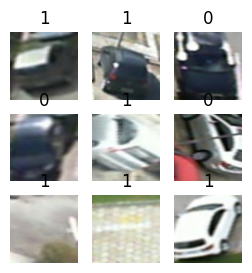

In [ ]:
show_images(train_ds)

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=0.15),
    tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    tf.keras.layers.RandomFlip(),
    tf.keras.layers.RandomContrast(factor=0.1),
    ], name="img_augmentation")

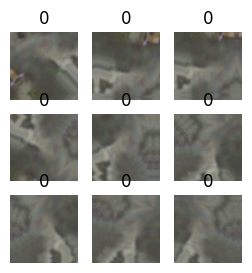

In [ ]:
show_images(train_ds, augmentation=True)

In [ ]:
augmented_train_ds = train_ds.map(lambda img, label : (data_augmentation(img), label),
                                  num_parallel_calls=tf.data.AUTOTUNE)

#(buffered) Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
def plot_hist(hist, acc='binary_accuracy'):
    plt.plot(hist.history[f"{acc}"])
    plt.plot(hist.history[f"val_{acc}"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

### Model 1:
**Yolo V8**

Since the Yolo model needs some special data directory order, we need to change the data directory


In [ ]:
#install necessary libraries
!pip install awscli
!pip install ultralytics

import ultralytics
IPython.display.clear_output()

In [ ]:
cls_data = './PKLot/PKLotSegmented'
train_path_1 = './data/train/Empty/'
train_path_2 = './data/train/Occupied/'
val_path_1   = './data/validation/Empty/'
val_path_2   = './data/validation/Occupied/'

os.makedirs(train_path_1, exist_ok=True)
os.makedirs(val_path_1, exist_ok=True)
os.makedirs(train_path_2, exist_ok=True)
os.makedirs(val_path_2, exist_ok=True)

VAL_THRESHOLD = 0.2
data_arr = []
limit = 40


data = pd.DataFrame(data_arr, columns=['path', 'label'])
for cat in os.listdir(cls_data):
  for crs in os.listdir(cls_data+'/'+cat):
    for day in os.listdir(cls_data+'/'+cat+'/'+crs):
      for E_O in os.listdir(cls_data+'/'+cat+'/'+crs+'/'+day):
        for img in os.listdir(cls_data+'/'+cat+'/'+crs+'/'+day+'/'+E_O)[:limit]:
          path = os.path.join(cls_data, cat, crs, day, E_O, img)
          folder_name = 'train' if np.random.randn()<VAL_THRESHOLD else 'validation'
          target = os.path.join('./data', folder_name, E_O, img)
          label = 0 if E_O == 'Empty' else 1
          data_arr.append([target, label])
          os.replace(path, target)
          break

data = pd.DataFrame(data_arr, columns=['path', 'label'])
data

In [ ]:
# model = YOLO('yolov8n.yaml').load('yolov8n-cls.pt')  # build from YAML and transfer weights
model = ultralytics.YOLO('yolov8n-cls.pt')
model.train(data='./data', epochs = 10, device='cpu', seed=32)

### model 2:
SVC model from sklearn since our data is so simple that CNN can't detect any patterns we can get a simpler model like SVC to handle this problem.

In [ ]:
x_train = []
y_train = []
x_test = []
y_test = []

for path, label in data_arr:
  folder = path.split('/')[2]
  img = skimage.io.imread(path)
  img = skimage.transform.resize(img, (20, 20))

  if folder == 'validation':
    x_test.append(img.flatten())
    y_test.append(label)
  else:
    x_train.append(img.flatten())
    y_train.append(label)


x_test = np.asarray(x_test)
y_test = np.asarray(y_test)
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(11584, 1200) (11584,)
(8402, 1200) (8402,)


In [ ]:
clf = svm.SVC()

parameters = [{'gamma': [0.01, 0.001, 0.0001], 'C': [1, 10, 100, 1000]}]

grid_search = model_selection.GridSearchCV(clf, parameters)

In [ ]:
grid_search.best_estimator_

SVC(C=10, gamma=0.01)

In [ ]:
grid_search.fit(x_train, y_train)

# test performance
best_estimator = grid_search.best_estimator_

y_prediction = best_estimator.predict(x_test)

score = metrics.accuracy_score(y_prediction, y_test)

print(f'{score * 100}% of samples were correctly classified')

pickle.dump(best_estimator, open('./drive/MyDrive/DATA/car_spot_model.p', 'wb'))

98.92882646988812% of samples were correctly classified


In [ ]:
test_data = []
test_label = []

for cat in os.listdir(cls_data):
  for crs in os.listdir(cls_data+'/'+cat):
    for day in os.listdir(cls_data+'/'+cat+'/'+crs):
      for E_O in os.listdir(cls_data+'/'+cat+'/'+crs+'/'+day):
        for img in os.listdir(cls_data+'/'+cat+'/'+crs+'/'+day+'/'+E_O):
          path = os.path.join(cls_data, cat, crs, day, E_O, img)
          folder_name = train_path if np.random.randn()<VAL_THRESHOLD else val_path
          target = os.path.join(folder_name, img)
          label = 0 if E_O == 'Empty' else 1
          test_data.append(path)
          test_label.append(label)


test = pd.DataFrame(test_data, columns=['path'])
test

,path
0,./PKLot/PKLotSegmented/UFPR04/Cloudy/2013-01-2...
1,./PKLot/PKLotSegmented/UFPR04/Cloudy/2013-01-2...
2,./PKLot/PKLotSegmented/UFPR04/Cloudy/2013-01-2...
3,./PKLot/PKLotSegmented/UFPR04/Cloudy/2013-01-2...
4,./PKLot/PKLotSegmented/UFPR04/Cloudy/2013-01-2...
...,...
695846,./PKLot/PKLotSegmented/UFPR05/Sunny/2013-04-10...
695847,./PKLot/PKLotSegmented/UFPR05/Sunny/2013-04-10...
695848,./PKLot/PKLotSegmented/UFPR05/Sunny/2013-04-10...
695849,./PKLot/PKLotSegmented/UFPR05/Sunny/2013-04-10...


In [ ]:
scores = []
for path, label in zip(test_data, test_label):
  folder = path.split('/')[2]
  img = skimage.io.imread(path)
  img = skimage.transform.resize(img, (20, 20))
  img = np.asarray(img.flatten())
  img = np.expand_dims(img, 0)
  pred = model.predict(img)
  score = metrics.accuracy_score(pred, [label])
  scores.append(score)

In [ ]:
totall_score = np.sum(scores) / len(scores)
print(f'{totall_score * 100:.4f}% of samples were correctly classified, from {len(scores)}')
print(f'In totall, The model got {int(np.sum(scores))} / {len(scores)} Right answer')
print(f'In totall, The model got {len(scores) - int(np.sum(scores))} / {len(scores)} Wrong answer')

99.3211% of samples were correctly classified, from 695851
In totall, The model got 691127 / 695851 Right answer
In totall, The model got 4724 / 695851 Wrong answer


#Parking Spot Detector

Efficient Object Detection with YOLOV8 and KerasCV

[kerasCV](https://keras.io/examples/vision/yolov8/)

In [29]:
cls_data = './PKLot/PKLotSegmented'
train_path_1 = './data/train/Empty/'
train_path_2 = './data/train/Occupied/'
val_path_1   = './data/validation/Empty/'
val_path_2   = './data/validation/Occupied/'

os.makedirs(train_path_1, exist_ok=True)
os.makedirs(val_path_1, exist_ok=True)
os.makedirs(train_path_2, exist_ok=True)
os.makedirs(val_path_2, exist_ok=True)

In [30]:
# VAL_THRESHOLD = 0.2
# data_arr = []
# limit = 40


# data = pd.DataFrame(data_arr, columns=['path', 'label'])
# for cat in os.listdir(cls_data):
#   for crs in os.listdir(cls_data+'/'+cat):
#     for day in os.listdir(cls_data+'/'+cat+'/'+crs):
#       for E_O in os.listdir(cls_data+'/'+cat+'/'+crs+'/'+day):
#         for img in os.listdir(cls_data+'/'+cat+'/'+crs+'/'+day+'/'+E_O)[:limit]:
#           path = os.path.join(cls_data, cat, crs, day, E_O, img)
#           folder_name = 'train' if np.random.randn()<VAL_THRESHOLD else 'validation'
#           target = os.path.join('./data', folder_name, E_O, img)
#           label = 0 if E_O == 'Empty' else 1
#           data_arr.append([target, label])
#           os.replace(path, target)
#           break

# data = pd.DataFrame(data_arr, columns=['path', 'label'])
# data

In [31]:
xml_files = []
jpg_files = []
data_path = '/content/PKLot/PKLot/'

for root, dirs, files in os.walk(data_path):
  for my_file in files:
    if my_file.endswith('.jpg') and os.path.exists(os.path.join(root,my_file[:-4]+'.xml')):
      jpg_files.append(os.path.join(root, my_file))
      xml_files.append(os.path.join(root, my_file[:-4]+'.xml'))

xml_files.sort()
jpg_files.sort()

len(xml_files), len(jpg_files)

(12416, 12416)

In [32]:
class_ids = ['Occupied', 'Empty']
class_mapping = dict(zip(range(len(class_ids)), class_ids))
class_mapping

{0: 'Occupied', 1: 'Empty'}

In [ ]:
      # for i, space in enumerate(root.iter('space')):
      #     # Extract the rotated rectangle and contour from the XML file
      #     rotated_rect = space.find('rotatedRect')
      #     contour = space.find('contour')
      #     center = rotated_rect.find('center')
      #     size = rotated_rect.find('size')
      #     angle = rotated_rect.find('angle')

      #     # Extract the values from the XML elements
      #     cx, cy = int(center.attrib['x']), int(center.attrib['y'])
      #     w, h = int(size.attrib['w']), int(size.attrib['h'])
      #     angle_deg = float(angle.attrib['d'])

      #     # Convert the angle to radians
      #     # angle_rad = angle_deg * (3.14159 / 180)

      #     # Extract the points from the contour
      #     pts = []
      #     for point in contour.iter('point'):
      #         x, y = int(point.attrib['x']), int(point.attrib['y'])
      #         pts.append((x, y))

In [ ]:
data = []
labels = []
coordinates = []
for xml, jpg in zip(xml_files[:20], jpg_files[:20]):
  img = cv2.imread(jpg)
  tree = ET.parse(xml)
  root = tree.getroot()
  root.attrib['id']
  coord = []
  coord_labels = []

  for space in  root.findall('space'):
    rotated_rect = space.find('rotatedRect')
    label = int(space.attrib['occupied'])
    for child in space:
      if child.tag == 'contour':
        cx, cy = int(center.attrib['x']), int(center.attrib['y'])
        w, h = int(size.attrib['w']), int(size.attrib['h'])
        x_y = []
        for point in child:
          x = int(point.attrib['x'])
          y = int(point.attrib['y'])
          x_y.append((x, y))

        coord.append(x_y)
        coord_labels.append(label)


  data.append(img)
  labels.append(coord_labels)
  coordinates.append(coord)



# with open(txt_path, "w") as txt_file:
#     for space in root.findall("space"):
#         occupied = space.get("occupied")
#         class_index = class_mapping.get(occupied, -1)

#         if class_index == -1:
#             continue

#         rotated_rect = space.find("rotatedRect")
#         center = rotated_rect.find("center")
#         size = rotated_rect.find("size")

#         center_x = float(center.get("x"))
#         center_y = float(center.get("y"))
#         width = float(size.get("w"))
#         height = float(size.get("h"))

#         x_center = center_x / image_width
#         y_center = center_y / image_height
#         w = width / image_width
#         h = height / image_height

#         txt_file.write(f"{class_index} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n")


In [2]:
def extract_parking_spaces(image_path, xml_path, save_dir='cropped_images', display_results=False, return_contours=False):

  for img_p, xml_p in zip(image_path, xml_path):
      # Load the image
      img = cv2.imread(img_p)
      img_contours = img.copy()

      # Load the XML file
      tree = ET.parse(xml_p)
      root = tree.getroot()

      # Define a list to store the cropped images
      cropped_images = []
      contours = []

      os.makedirs(save_dir, exist_ok=True)

      # Iterate over the spaces in the XML file
      for space in root.iter('space'):
          # Extract the rotated rectangle and contour from the XML file
          rotated_rect = space.find('rotatedRect')
          contour = space.find('contour')
          center = rotated_rect.find('center')
          size = rotated_rect.find('size')
          angle = rotated_rect.find('angle')

          # Extract the values from the XML elements
          cx, cy = int(center.attrib['x']), int(center.attrib['y'])
          w, h = int(size.attrib['w']), int(size.attrib['h'])
          angle_deg = float(angle.attrib['d'])

          # Convert the angle to radians
          # angle_rad = angle_deg * (3.14159 / 180)

          # Extract the points from the contour
          pts = []
          for point in contour.iter('point'):
              x, y = int(point.attrib['x']), int(point.attrib['y'])
              pts.append((x, y))

          # Create a mask for the polygon
          mask = np.zeros(img.shape[:2], dtype=np.uint8)
          cv2.fillPoly(mask, [np.array(pts)], (255, 255, 255))

          # Rotate the mask by the angle
          M = cv2.getRotationMatrix2D((cx, cy), angle_deg, 1)
          rotated_mask = cv2.warpAffine(mask, M, (img.shape[1], img.shape[0]))

          # Crop the region from the image
          cropped = cv2.bitwise_and(img, img, mask=rotated_mask)

          # Find the bounding box of the contour
          x, y, w, h = cv2.boundingRect(np.array(pts))
          # Crop the region of interest from the cropped image
          roi = img[y:y+h, x:x+w]

          # Resize the region of interest to 100x100
          resized_roi = cv2.resize(roi, (100, 100))

          # Append the cropped image to the list
          cropped_images.append(resized_roi)
          colors = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))

          # Draw the contour on the image
          cv2.drawContours(img_contours, [np.array(pts)], 0, colors, 2)

          contours.append(np.array(pts))

      if display_results:
          plt.grid(linewidth=0)
          plt.imshow(img_contours)
          plt.show()

      # Convert the list of cropped images to a numpy array
      cropped_images_array = np.array(cropped_images)

      contours = np.array(contours)

      if return_contours:
              return cropped_images_array, contours

  return cropped_images_array

In [ ]:

res = extract_parking_spaces([jpg_files[9000]], [xml_files[9000]], display_results=True)
res.shape

In [4]:
json_file = '/content/drive/MyDrive/DATA/2012-12-12_10_00_05.json'

In [25]:
# def extract_parking_spaces(image_path, xml_path, save_dir='cropped_images', display_results=False, return_contours=False):

#   for img_p, xml_p in zip(image_path, xml_path):
#       # Load the image
#       img = cv2.imread(img_p)
#       img_contours = img.copy()

#       # Load the XML file
#       tree = ET.parse(xml_p)
#       root = tree.getroot()

#       # Define a list to store the cropped images
#       cropped_images = []
#       contours = []

#       os.makedirs(save_dir, exist_ok=True)


#       with open(json_file) as f:
#         json_dic = json.load(f)

#       pts = []
#       for shape in json_dic['shapes']:
#           points = shape['points']
#           for p in points:
#              pts.append((int(p[0]), int(p[1])))
#       # Extract the points from the contour
#       # Create a mask for the polygon
#       mask = np.zeros(img.shape[:2], dtype=np.uint8)
#       cv2.fillPoly(mask, [np.array(pts)], (255, 255, 255))

#       # Crop the region from the image
#       cropped = cv2.bitwise_and(img, img, mask=mask)

#       # Find the bounding box of the contour
#       x, y, w, h = cv2.boundingRect(np.array(pts))
#       # Crop the region of interest from the cropped image
#       roi = img[y:y+h, x:x+w]

#       # Resize the region of interest to 100x100
#       resized_roi = cv2.resize(roi, (100, 100))

#       # Append the cropped image to the list
#       cropped_images.append(resized_roi)
#       colors = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))

#       # Draw the contour on the image
#       cv2.drawContours(img_contours, [np.array(pts)], 0, colors, 2)

#       contours.append(np.array(pts))

#       if display_results:
#           plt.grid(linewidth=0)
#           plt.imshow(img_contours)
#           plt.show()

#       # Convert the list of cropped images to a numpy array
#       cropped_images_array = np.array(cropped_images)

#       contours = np.array(contours)

#       if return_contours:
#               return cropped_images_array, contours

#   return cropped_images_array

# res = extract_parking_spaces([jpg_files], [xml_files], display_results=True)
# res.shape

[(238, 255), (260, 315), (331, 299), (306, 236), (302, 212), (324, 269), (386, 256), (358, 198), (476, 185), (429, 200), (402, 156), (448, 141), (444, 129), (469, 170), (517, 159), (486, 116), (553, 130), (518, 96), (483, 107), (512, 147), (548, 81), (576, 116), (545, 122), (514, 90), (576, 114), (610, 104), (582, 71), (549, 80), (241, 271), (269, 347), (187, 364), (170, 287), (170, 286), (190, 401), (107, 422), (99, 341), (175, 326), (101, 376), (104, 470), (11, 491), (19, 391), (20, 499), (132, 475), (144, 605), (10, 626), (131, 427), (190, 413), (202, 485), (139, 501), (279, 316), (357, 298), (374, 330), (292, 351), (344, 267), (385, 344), (457, 319), (408, 253), (400, 232), (438, 288), (498, 268), (457, 216), (355, 183), (378, 232), (437, 220), (401, 171), (445, 198), (495, 180), (539, 225), (480, 246), (489, 173), (538, 152), (585, 191), (526, 211), (526, 144), (574, 185), (616, 163), (568, 122), (563, 123), (615, 166), (651, 143), (610, 102), (610, 103), (647, 140), (679, 119), (

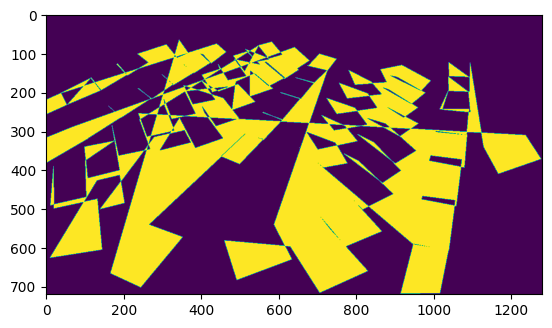

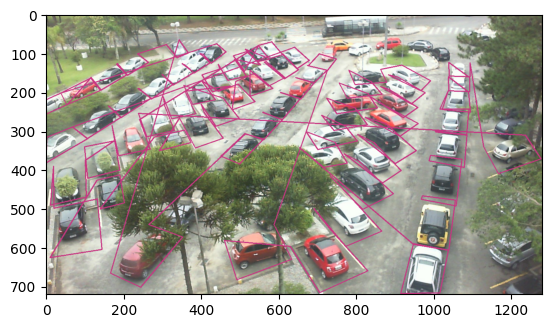

In [43]:
jpg_files = '/content/drive/MyDrive/DATA/2012-12-12_10_00_05.jpg'
xml_files = '/content/drive/MyDrive/DATA/2012-12-12_10_00_05.json'

# Load the image
img = cv2.imread(jpg_files)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_contours = img.copy()
# Define a list to store the cropped images
cropped_images = []
contours = []

with open(json_file) as f:
  json_dic = json.load(f)

pts = []
for shape in json_dic['shapes']:
  points = shape['points']
  for p in points:
    pts.append((int(p[0]), int(p[1])))
print(pts)
# Extract the points from the contour
# Create a mask for the polygon
mask = np.zeros(img.shape[:2], dtype=np.uint8)
cv2.fillPoly(mask, [np.array(pts)], (255, 255, 255))
plt.imshow(mask)
plt.show()
# Crop the region from the image
cropped = cv2.bitwise_and(img, img, mask=mask)

# Find the bounding box of the contour
x, y, w, h = cv2.boundingRect(np.array(pts))
# Crop the region of interest from the cropped image
roi = img[y:y+h, x:x+w]

# Resize the region of interest to 100x100
# resized_roi = cv2.resize(roi, (100, 100))
resized_roi = roi

# Append the cropped image to the list
cropped_images.append(resized_roi)
colors = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))

# Draw the contour on the image
cv2.drawContours(img_contours, [np.array(pts)], 0, colors, 2)

contours.append(np.array(pts))

plt.grid(linewidth=0)
plt.imshow(img_contours)
plt.show()

# Convert the list of cropped images to a numpy array
cropped_images_array = np.array(cropped_images)

contours = np.array(contours)

In [22]:
# /content/drive/MyDrive/DATA/2012-10-25_08_23_19.jpg
# /content/drive/MyDrive/DATA/2012-12-12_10_00_05.json
# /content/drive/MyDrive/DATA/2013-03-09_13_10_08.json

jpg_files = '/content/drive/MyDrive/DATA/2012-12-12_10_00_05.jpg'
xml_files = '/content/drive/MyDrive/DATA/2012-12-12_10_00_05.json'
res = extract_parking_spaces([jpg_files], [xml_files], display_results=True)
res.shape

ParseError: ignored

In [ ]:
import json

with open(json_file) as f:
    json_dic = json.load(f)

for shape in json_dic['shapes']:
  points = shape['points']
  print(points)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import EfficientNetV2S

# Define the input shape
input_shape = (100, 100, 3)

# Load the pre-trained ConvNeXt50 model
base_model = EfficientNetV2S(weights="imagenet", include_top=False, input_shape=input_shape)

# Freeze the weights of the pre-trained tf.keras.layers
for layer in base_model.layers:
    layer.trainable = False

# Add a classification head to the model
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(units=256, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(units=2, activation="softmax")(x)

model = keras.Model(inputs=base_model.input, outputs=outputs)

model.summary()
tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)

In [ ]:
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

early_stopping = EarlyStopping(
                                patience=25, # wait for 5 epochs
                                min_delta = 0.01, # if in 5 epochs the loss function doesn't inrease (for accuracy)
                                               # or decrease (for val_loss) by 1%, then stop
                                verbose=1, # print the training epoch on which training was stopped
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=10, # if val_loss plateaus for 3 epochs such that it doesn't see
                                                # an improvement of size = epsilon
                                    episilon= 0.1,
                                    factor=0.1,  # then we reduce the learning rate by a factor of 0.1
                                    cooldown = 2, # and we wait for 4 epochs before we restart again
                                    verbose=1)

time_callback = TimingCallback()


# hyperparameters
lr = 0.001
batch_size = 256

In [ ]:
from keras.utils import to_categorical

# Define the number of epochs and batch size
epochs = 50
batch_size = 256

# Define the optimizer and loss function
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.CategoricalCrossentropy()

# define dictionary to hold accuracy results
accuracy_dict = {}
y_train_resampled = to_categorical(y_train_resampled)

for model_name, model in models.items():
    print(f'Training {model_name}')
    # compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # convert labels to one-hot encoded format

    # train model
    history = model.fit(
        x_train, y_train_resampled,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping, reduce_learning_rate, time_callback],
        verbose=1,
    )


    # Evaluate the model on the validation data
    loss, accuracy = model.evaluate(x_val, y_val)
    print('{} validation accuracy: {:.2f}%'.format(model_name, accuracy * 100))

    accuracy_dict[model_name] = accuracy


    # Plot the learning curves and accuracy curves
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.suptitle(model_name)
    plt.show()

In [ ]:
def make_predictions(image_path, xml_path, classifier=None, display_results=True):
    lots, contours = extract_parking_spaces(image_path, xml_path, display_results=True, return_contours=True)
    img = cv2.imread(image_path)
    # Draw a green box if label is occupied, red if it's not
    if classifier is not None:
        for i, lot in enumerate(lots):
            # Use the classifier to make a prediction on the input image
            lot = np.expand_dims(lot, axis=0)
            prediction = classifier.predict(lot, verbose=0)
            prediction = np.argmax(prediction)

            # Draw a green box if label is occupied, red if it's not
            color = (0, 255, 0) if prediction == 1 else (0, 0, 255)
            cv2.drawContours(img, [contours[i]], 0, color, 2)

    if display_results:
        plt.grid(linewidth=0)
        plt.imshow(img)
        plt.show()

In [ ]:
make_predictions(jpg_files[0], xml_files[0], classifier=model)

In [ ]:
def parse_annotation(xml_f):
    tree = ET.parse(xml_f)
    root = tree.getroot()

    boxes = []
    classes = []
    for obj in root.iter("object"):
        cls = obj.find("name").text
        classes.append(cls)

        bbox = obj.find("bndbox")
        xmin = float(bbox.find("xmin").text)
        ymin = float(bbox.find("ymin").text)
        xmax = float(bbox.find("xmax").text)
        ymax = float(bbox.find("ymax").text)
        boxes.append([xmin, ymin, xmax, ymax])

    class_ids = [list(class_mapping.keys())[list(class_mapping.values()).index(cls)] for cls in classes]
    return boxes, class_ids


image_paths = []
bbox = []
classes = []
for xml_f, jpg_f in zip(xml_files, jpg_files):
    boxes, class_ids = parse_annotation(xml_f)
    image_paths.append(jpg_f)
    bbox.append(boxes)
    classes.append(class_ids)

In [ ]:
print(classes[:4])
bbox[:4]

[[], [], [], []]


[[], [], [], []]

In [ ]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0

In [ ]:
augmenter = tf.keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"),
        keras_cv.layers.JitteredResize(target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"),
          ]
      )

In [ ]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

# Determine the number of validation samples
num_val = int(len(xml_files) * SPLIT_RATIO)
print(len(xml_files), num_val, len(xml_files)-num_val)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

2682 536 2146


In [ ]:
def load_dataset(image_path, classes, bbox):
    # Read Image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    bounding_boxes = {"classes": tf.cast(classes, dtype=tf.float32), "boxes": bbox}
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

Creating Training Dataset


In [ ]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy")

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

### Generate Images to predict

In [ ]:
stable_diffusion = keras_cv.models.StableDiffusionV2(512, 512)
images = stable_diffusion.text_to_image(
    prompt="A zoomed out photograph of a cool looking cat.  The cat stands in a beautiful forest",
    negative_prompt="unrealistic, bad looking, malformed",
    batch_size=4,
    seed=1231,
)
y_pred = model.predict(images)
visualization.plot_bounding_box_gallery(
    images,
    value_range=(0, 255),
    y_pred=y_pred,
    rows=2,
    cols=2,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)